In [1]:
import torch
import triton
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from dyt import DYT
from rmsnorm import TritonRMSNorm

In [5]:
dtype = torch.bfloat16
device = 'cuda'
bs, seq_len, dim = 1, 2048, 4096
beta = True
x1 = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
x1.requires_grad_(True)

x2 = deepcopy(x1)
dyt1 = DYT(dim, beta=beta).to(device).to(dtype)
dyt1.gemma.data.copy_(torch.randn(dim))
if beta:
    dyt1.beta.data.copy_(torch.randn(dim))
dyt2 = deepcopy(dyt1)


In [6]:
y1 = dyt1(x1, "torch")
y2 = dyt2(x2, "triton")
dy = torch.randn_like(y1)
y1.backward(dy)
y2.backward(dy)
print((y1-y2).abs().max(), (y1-y2).abs().mean())
print((x1.grad-x2.grad).abs().max(), (x1.grad-x2.grad).abs().mean())
print((dyt1.gemma.grad-dyt2.gemma.grad).abs().max(), (dyt1.gemma.grad-dyt2.gemma.grad).abs().mean())
if beta:
    print((dyt1.beta.grad-dyt2.beta.grad).abs().max(), (dyt1.beta.grad-dyt2.beta.grad).abs().mean())
print((dyt1.alpha.grad-dyt2.alpha.grad).abs() / dyt1.alpha.grad.abs())


tensor(0.0312, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0006, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor(0.0312, device='cuda:0', dtype=torch.bfloat16) tensor(0.0005, device='cuda:0', dtype=torch.bfloat16)
tensor(0.2500, device='cuda:0', dtype=torch.bfloat16) tensor(0.0354, device='cuda:0', dtype=torch.bfloat16)
tensor(0., device='cuda:0', dtype=torch.bfloat16) tensor(0., device='cuda:0', dtype=torch.bfloat16)
tensor([1.], device='cuda:0', dtype=torch.bfloat16)


In [ ]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-DYT', "Torch-DYT", 'RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-DYT",
            "Torch-DYT",
            "RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8, 'beta': True}
    ))
def benchmark(bs, seq_len, dim, beta, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'Triton-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: dyt(tensor, 'triton'))
    if provider == 'Torch-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: dyt(tensor, 'torch'))
    if provider == 'RMSNorm':
        norm = TritonRMSNorm(dim).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: norm(tensor))
    return ms
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


bs: 8, seq_len: 1024


bs: 8, seq_len: 1024


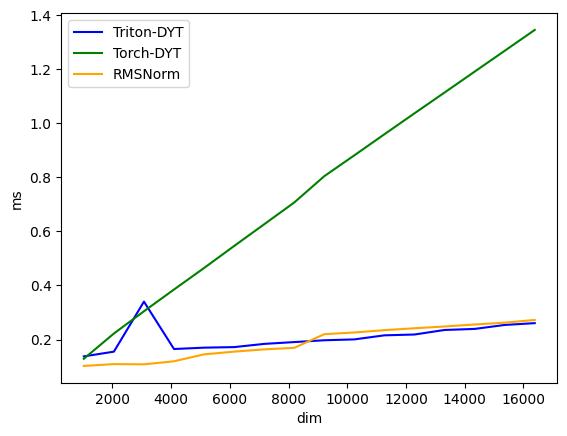

backward:
        dim  Triton-DYT  Torch-DYT   RMSNorm
0    1024.0    0.137812   0.128883  0.102465
1    2048.0    0.155185   0.222371  0.109225
2    3072.0    0.340236   0.304599  0.108357
3    4096.0    0.164981   0.385106  0.119602
4    5120.0    0.170004   0.464626  0.145243
5    6144.0    0.172071   0.546023  0.155304
6    7168.0    0.183945   0.626393  0.163649
7    8192.0    0.190665   0.707010  0.169398
8    9216.0    0.197384   0.804259  0.219963
9   10240.0    0.200574   0.881456  0.226200
10  11264.0    0.215609   0.959371  0.234790
11  12288.0    0.218648   1.036782  0.241732
12  13312.0    0.235410   1.113648  0.248305
13  14336.0    0.239318   1.190919  0.255676
14  15360.0    0.253997   1.267950  0.262465
15  16384.0    0.260698   1.345222  0.272464


In [ ]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-DYT', "Torch-DYT", 'RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-DYT",
            "Torch-DYT",
            "RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8, 'beta':True}
    ))
def benchmark(bs, seq_len, dim, beta, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    tensor.requires_grad_(True)
    dy = torch.rand_like(tensor)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'Triton-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        y = dyt(tensor, 'triton')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    if provider == 'Torch-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        y = dyt(tensor, 'torch')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    if provider == 'RMSNorm':
        norm = TritonRMSNorm(dim).to(device).to(dtype)
        y = norm(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    return ms
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)
